In [1]:
# pip install ipython-sql

%load_ext sql
%sql postgresql://###

'Connected: ###'

In [2]:
df= %sql select user_emails.user_id, user_emails.email, gmail_accounts.refresh_token from user_emails inner join gmail_accounts on user_emails.user_id = gmail_accounts.user_id where gmail_accounts.refresh_token <> 'None'
df = df.DataFrame()

30080 rows affected.


In [3]:
from oauth2client.client import GoogleCredentials
from apiclient import discovery
import pandas as pd
import langdetect
import base64
import email

In [4]:
QueryTable = pd.read_csv(r'./Desktop/QueryKeys.csv')

QueryTable = QueryTable.dropna(axis=0, how='all')
QueryTable.drop(['Category', 'Is', 'Prob'], inplace=True, axis=1)
QueryTable['From'] = QueryTable['From'].str.replace('from:', '')
QueryTable = QueryTable.apply(lambda x: x.astype(str).str.lower())
QueryGroups = QueryTable.groupby(['Lang', 'Subject', 'Audience'])

LanguageSubjectAudience = {'en' : ('order', QueryTable[QueryTable['Lang'] == 'en']['Audience'].unique()),
                              'de' : ('bestellung', QueryTable[QueryTable['Lang'] == 'de']['Audience'].unique())}

In [5]:
AudienceKeywordList = {}

for Language in LanguageSubjectAudience.keys():
    
    AudienceKeywordList[Language] = {}
    Subject, AudienceList = LanguageSubjectAudience[Language]
    
    for Audience in AudienceList:
        
        AudienceKeywordList[Language][Audience] = {}
        FromKeywordPairs = QueryTable[['From', 'Keywords']].loc[QueryGroups.groups[(Language, 'subject:' + Subject, Audience)]]
        FromKeywordGroups = FromKeywordPairs.groupby(['From'])
        
        for FromWord in FromKeywordGroups.From.all():
            
            KeywordList = FromKeywordPairs['Keywords'].loc[FromKeywordGroups.groups[FromWord]]
            KeywordListClean = []
            
            for Item in KeywordList.str.split('"'):
                for Sub_Item in Item:
                    if Sub_Item == 'nan':
                        KeywordListClean.append('')                        
                    elif (2 < len(Sub_Item) < 50):
                        KeywordListClean.append(Sub_Item)
                        
            AudienceKeywordList[Language][Audience][FromWord] = KeywordListClean
            
del AudienceKeywordList['en']['mac']['mac']

In [6]:
SCOPES = 'https://www.googleapis.com/auth/gmail.readonly'
CLIENT_SECRET_FILE = 'client_secret.json'
APPLICATION_NAME = 'Gmail API Python Quickstart'
CLIENT_ID = '551704684391-7rh6n6ejp663lp5gmgokme0jhujde9tg.apps.googleusercontent.com'
CLIENT_SECRET = 'RfjUAt9d7inrYby3AltFdMum'
TOKEN_URI = 'https://accounts.google.com/o/oauth2/token'
USER_AGENT = 'peopleio-prod'


UserAudienceGmailCounts = {}

for idx, (User_ID, User_Email, REFRESH_TOKEN) in df.iterrows():
    
    UserAudienceGmailCounts[User_ID] = {}
    
    try:
        credentials = GoogleCredentials(None, CLIENT_ID, CLIENT_SECRET, REFRESH_TOKEN, None, TOKEN_URI, USER_AGENT)
        service = discovery.build('gmail', 'v1', credentials=credentials)
        results = service.users().messages().list(userId='me', labelIds='INBOX', q='newer_than:30d is:read {subject:order subject:bestellung}', maxResults=1000).execute()

        #print('Access for User No: {}, Email: {} Successful!'.format(idx+1, User_Email))


        if results.get('messages', []):

            for i, message in enumerate(results.get('messages', [])):

                msg_raw = service.users().messages().get(userId='me', id=message['id'], format='raw').execute()
                msg = base64.urlsafe_b64decode(msg_raw['raw'].encode('ASCII'))
                msg = email.message_from_string(msg.decode('utf-8'))

                #print('\n{}. email of User {}:'.format(i+1, idx+1))

                if msg_raw['snippet']:

                    if isinstance(msg.get_payload(), list):
                        MessageContent = msg.get_payload()[0].get_payload().lower()
                    else:
                        MessageContent = msg.get_payload().lower()

                    Language = (langdetect.detect(msg_raw['snippet']))
                    Subject, AudienceList = LanguageSubjectAudience[Language] 

                    for Audience in AudienceList:
                        for FromWord in AudienceKeywordList[Language][Audience].keys():
                            if (FromWord in msg.get('From').lower()) and any(Keyword in MessageContent for Keyword in AudienceKeywordList[Language][Audience][FromWord]):
                                
                                print('............ Query Found .............')
                                print('\n{}. email of User {}:\n'.format(i+1, idx+1))
                                print('Audience: {}'.format(Audience))
                                print('FromWord: {}'.format(FromWord))
                                print('From: {}'.format(msg.get('From').lower()))
                                print('Subject: {}\n'.format(msg.get('Subject')))
                                
                                if Audience in UserAudienceGmailCounts[User_ID].keys():
                                    UserAudienceGmailCounts[User_ID][Audience] += 1
                                else:
                                    UserAudienceGmailCounts[User_ID][Audience] = 1
                                break

                #else:
                    #print('Language: Not English or German!')
                    #continue

        #else:
            #continue
            #print('No message found to print!')

    except:
        continue
        #print('\nAccess for User {}: Unsuccessful!\n'.format(User_ID))

............ Query Found .............

5. email of User 28:

Audience: amazon
FromWord: auto-confirm@amazon.co.uk
From: "amazon.co.uk" <auto-confirm@amazon.co.uk>
Subject: Your Amazon.co.uk order of "Chaos Walking: A Trilogy ..." and 7
 more item(s)

............ Query Found .............

5. email of User 28:

Audience: face & bodycare
FromWord: auto-confirm@amazon.co.uk
From: "amazon.co.uk" <auto-confirm@amazon.co.uk>
Subject: Your Amazon.co.uk order of "Chaos Walking: A Trilogy ..." and 7
 more item(s)

............ Query Found .............

5. email of User 28:

Audience: cosmetics brands
FromWord: auto-confirm@amazon.co.uk
From: "amazon.co.uk" <auto-confirm@amazon.co.uk>
Subject: Your Amazon.co.uk order of "Chaos Walking: A Trilogy ..." and 7
 more item(s)

............ Query Found .............

5. email of User 28:

Audience: cosmetology
FromWord: auto-confirm@amazon.co.uk
From: "amazon.co.uk" <auto-confirm@amazon.co.uk>
Subject: Your Amazon.co.uk order of "Chaos Walking: A Tr

In [7]:
for User in UserAudienceGmailCounts.keys():
    if UserAudienceGmailCounts[User]:
        print('\nCounts for User {}'.format(User))
        print(UserAudienceGmailCounts[User])


Counts for User 65879
{'junk food': 2, 'meat': 2, 'online food order': 2, 'iceland': 2, 'frozen food': 2, 'dairy & eggs': 2}

Counts for User 65944
{'online food order': 1, 'dairy & eggs': 1, 'junk food': 1, 'sainsburys': 1, 'soft drink': 1, 'snack': 1, 'bread': 1}

Counts for User 65947
{'soft drink': 1, 'online food order': 1, 'asda': 1}

Counts for User 66327
{'currys': 1, 'google': 1}

Counts for User 848
{'cosmetics brands': 2, 'rimmel': 2, 'face & bodycare': 2, 'nyx': 2, 'boots': 2, 'cosmetology': 2}

Counts for User 66508
{'calvin klein': 2, 'cosmetics brands': 2, 'amazon': 2, 'cosmetology': 2, 'face & bodycare': 2}

Counts for User 32769
{'tesco': 1, 'condiments & dressings': 1, 'soft drink': 1, 'dairy & eggs': 1, 'online food order': 1}

Counts for User 66718
{'sony': 1, 'argos': 1, 'casio': 1}

Counts for User 1226
{'face & bodycare': 1, 'cosmetology': 1, 'cosmetics brands': 1}

Counts for User 66879
{'sainsburys': 3, 'snack': 3, 'bread': 3, 'online food order': 3, 'dairy & 

In [11]:
import json
with open(r'.\Desktop\UserAudienceGmailCounts.txt', 'w') as txtFile:
    json.dump(UserAudienceGmailCounts, txtFile)

In [2]:
import json

In [3]:
UserAudienceGmailCounts = json.load(open(r'./Desktop/UserAudienceGmailCounts.txt'))

In [4]:
len(UserAudienceGmailCounts.keys())

29668

In [23]:
for User in UserAudienceGmailCounts.keys():
    if UserAudienceGmailCounts[User]:
        print('\nCounts for User {}'.format(User))
        print(UserAudienceGmailCounts[User])
        print(UserAudienceGmailCounts[User].values())


Counts for User 95604
{'cosmetology': 1}
dict_values([1])

Counts for User 50990
{'frozen food': 1, 'nutritional supplements': 1, 'bread': 1, 'baked goods': 1, 'snack': 1, 'soft drink': 1, 'condiments & dressings': 1, 'sainsburys': 1, 'online food order': 1, 'cleaning supplies & services': 1}
dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Counts for User 51398
{'cosmetics brands': 2, 'miss sporty': 2, 'face & bodycare': 2, 'superdrug': 2, 'mua': 2, 'makeup revolution': 2, 'cosmetology': 2}
dict_values([2, 2, 2, 2, 2, 2, 2])

Counts for User 27959
{'argos': 1, 'microsoft': 1, 'apple': 1}
dict_values([1, 1, 1])

Counts for User 48147
{'nyx': 1, 'cosmetics brands': 1, 'cosmetology': 1, 'face & bodycare': 1, 'boots': 1}
dict_values([1, 1, 1, 1, 1])

Counts for User 28156
{'house of fraser': 1, 'clarins': 1, 'face & bodycare': 1, 'cosmetics brands': 1, 'cosmetology': 1}
dict_values([1, 1, 1, 1, 1])

Counts for User 57353
{'iceland': 1, 'cleaning supplies & services': 1, 'online food order': 

In [24]:
UserQueryDist = []

for User in UserAudienceGmailCounts.keys():
    if UserAudienceGmailCounts[User]:
        UserQueryDist.append(sum(UserAudienceGmailCounts[User].values()))

In [27]:
UserQueryDist = pd.DataFrame(UserQueryDist, columns=['Count'])

In [26]:
import pandas as pd

In [28]:
UserQueryDist.head()

,Count
0,1
1,10
2,14
3,3
4,5


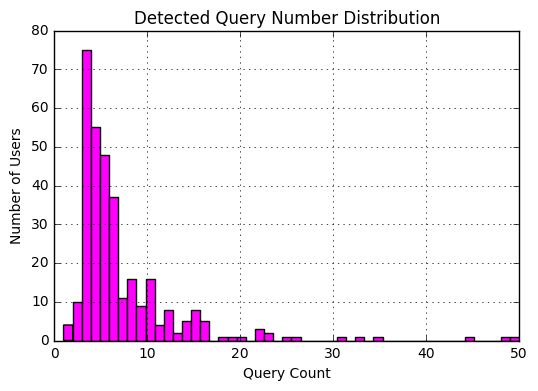

In [49]:
UserQueryDist['Count'].plot(kind='hist', bins=50, normed=False, color='magenta', grid=True)
UserQuery = plt.gcf()
#plt.ylim([0, 0.025])
plt.xlabel('Query Count')
plt.ylabel('Number of Users')
plt.title('Detected Query Number Distribution')

UserQuery.savefig(r'.\Desktop\DetQueryDist.png')

In [207]:
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
len(UserQueryDist)

329

In [52]:
UserQueryDist.mean()

Count    6.917933
dtype: float64

In [137]:
FoundAudiences = []
for Audiences in UserAudienceGmailCounts.values():
    FoundAudiences = list(set(FoundAudiences + list(Audiences.keys())))

In [138]:
AudienceCount = pd.DataFrame(0, index=FoundAudiences, columns=['Count'])

for Audiences in UserAudienceGmailCounts.values():
    AudienceCount['Count'].loc[list(Audiences.keys())] += list(Audiences.values())

In [139]:
AudienceCount.head(10)

,Count
cosmetology,150.0
baked goods,17.0
8x4,4.0
cleaning supplies & services,46.0
mac,1.0
nutritional supplements,7.0
tesco,77.0
neutrogena,2.0
braun,4.0
philips,1.0


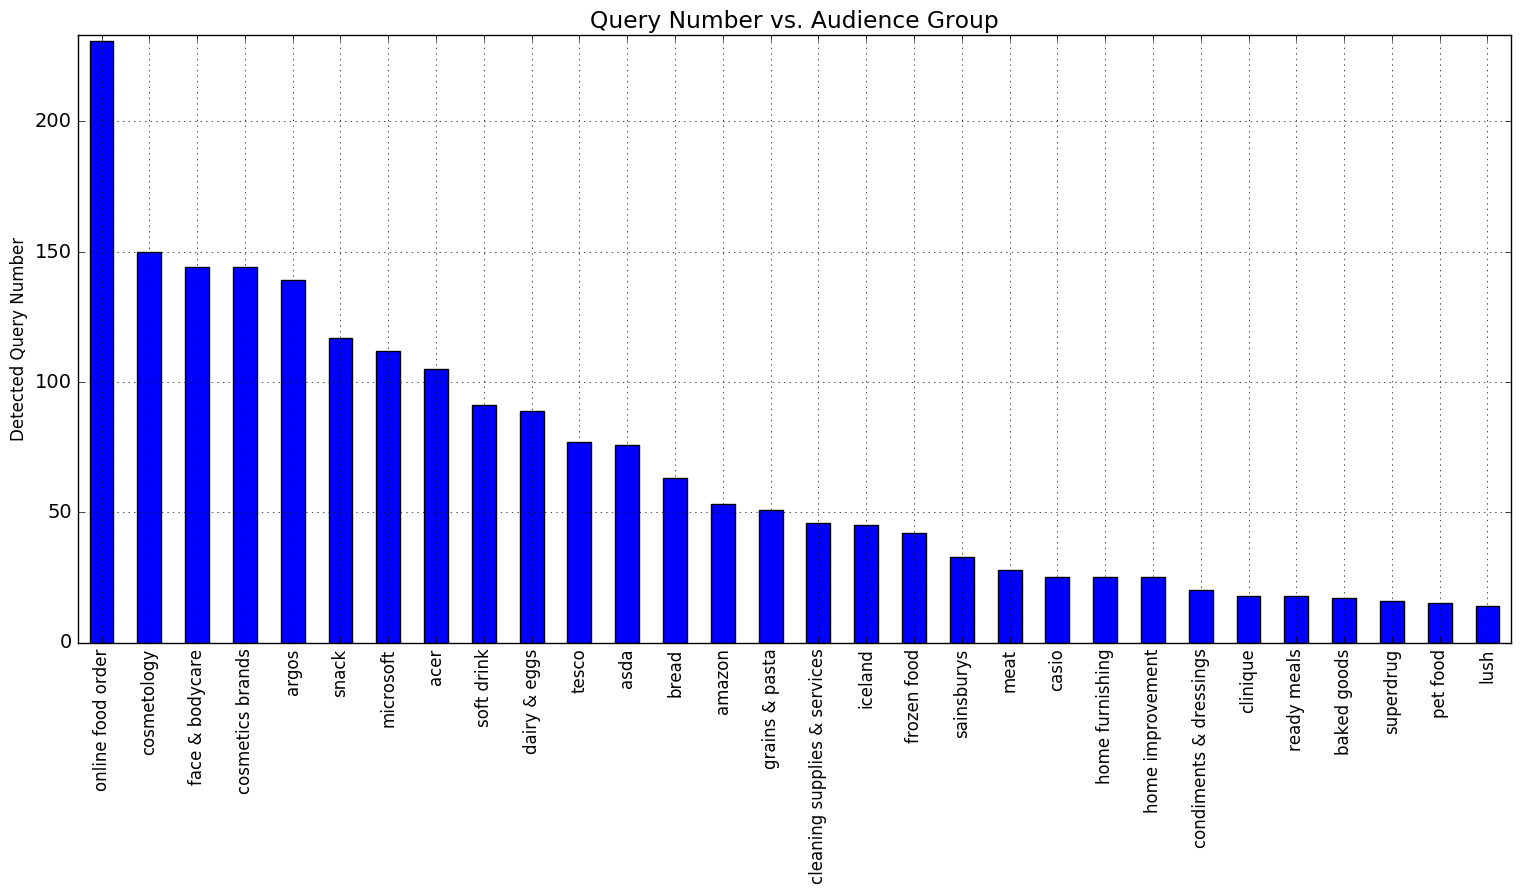

In [194]:
AudienceCount.sort_values(by='Count', ascending=False)[:30].plot(kind='bar', legend=None)
AudienceCountFig = plt.gcf()
plt.ylim([0, 1.01*AudienceCount['Count'].max()])
#plt.xlabel('Audience')
plt.ylabel('Detected Query Number')
plt.title('Query Number vs. Audience Group')
#plt.rc('xtick', labelsize=12)
#plt.rc('ytick', labelsize=14)
plt.rc('font', size=14)
plt.rc('axes', labelsize=12)
plt.grid()
plt.gcf().subplots_adjust(bottom=0.26)

AudienceCountFig.set_size_inches(18.5, 9.5)
AudienceCountFig.savefig(r'.\Desktop\AudQueryDist.png')

In [195]:
import pandas as pd
import numpy as np
UserAudienceGmailCounts = json.load(open(r'./Desktop/UserAudienceGmailCounts.txt'))

In [254]:
Audience = 'snack'
AudienceCount = []

for Audiences in UserAudienceGmailCounts.values():
    if Audience in Audiences.keys():
        AudienceCount.append(Audiences[Audience])

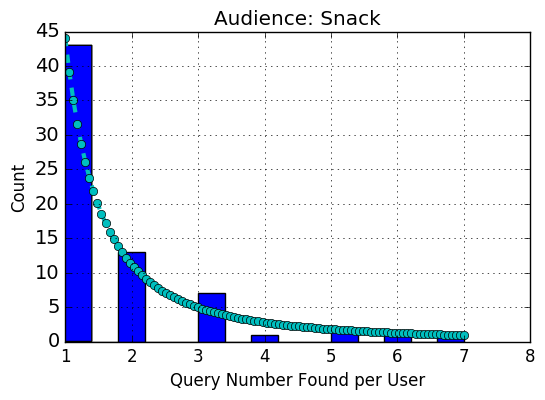

In [365]:
Aud_1 = plt.gcf()

n, bins, patches = plt.hist(AudienceCount, bins=15, normed=False)

_, loc, scale = powerlaw.fit(n)
x = np.linspace(1, bins[-1], 100)
y = scale*x**(-1.988)

plt.plot(x, y, color='c', linestyle='--', marker='o', linewidth=3)
plt.ylim([0, 45])
plt.xlim([1, 8])
plt.xlabel('Query Number Found per User')
plt.ylabel('Count')
plt.title('Audience: Snack')
#plt.rc('xtick', labelsize=12)
#plt.rc('ytick', labelsize=14)
plt.rc('font', size=12)
plt.rc('axes', labelsize=12)
plt.grid()
#plt.gcf().subplots_adjust(bottom=0.26)

#Aud_1.set_size_inches(18.5, 9.5)
Aud_1.savefig(r'.\Desktop\Fit.png')

In [366]:
y.cumsum()

array([  44.04769388,   83.23285313,  118.31966117,  149.92005168,
        178.52983582,  204.55500723,  228.33120535,  250.13832702,
        270.21164116,  288.7503455 ,  305.9242269 ,  321.87889821,
        336.73995437,  350.61629938,  363.60283097,  375.78262309,
        387.22871253,  398.00557103,  408.17032557,  417.77377582,
        426.86124692,  435.4733079 ,  443.64637994,  451.41325342,
        458.80352964,  465.84399945,  472.55896925,  478.97054259,
        485.09886429,  490.96233284,  496.57778571,  501.96066153,
        507.12514249,  512.08427966,  516.85010363,  521.43372236,
        525.84540804,  530.09467423,  534.19034473,  538.14061497,
        541.95310698,  545.63491875,  549.19266849,  552.63253452,
        555.96029126,  559.18134171,  562.30074684,  565.32325228,
        568.25331249,  571.09511277,  573.85258931,  576.52944745,
        579.12917838,  581.65507438,  584.11024281,  586.49761894,
        588.81997764,  591.07994427,  593.28000458,  595.42251

In [367]:
y.sum()/2

325.4841685856851

In [413]:
first_idx = np.argmax(y.cumsum() >= y.sum()*0.5)

In [414]:
x[first_idx]

1.7272727272727273

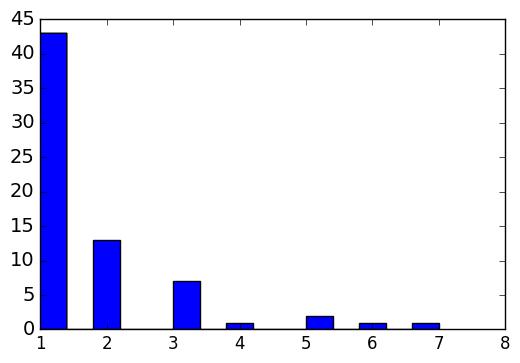

In [420]:
# final integration

# simple counts of queries found for each audience
AudCount = np.array(AudienceCount)
# transformation: standard scores
SS = (AudCount - AudCount.mean())/AudCount.std()
# transformation: rescaling to [0,1]
RSS = (SS - SS.min())/SS.ptp() 

# power law fit
n, bins, patches = plt.hist(AudienceCount, bins=15, normed=False)
_, loc, scale = powerlaw.fit(n)
x = np.linspace(1, bins[-1], 100)
y = scale*x**(-1.988)

# finding index for half of population being represented
first_idx = np.argmax(y.cumsum() >= y.sum()*0.5)

# finding alpha value
SS1 = (x[first_idx] - AudCount.mean())/AudCount.std()
SS1 = (SS1 - SS.min()) / SS.ptp()

alpha = -np.log(0.5) / SS1

# final AS score for the User-Audience
ASQ_U = 0.2
RSS_U = 0.4
AS_Unif = 1 - (1 - ASQ_U)*np.exp(-alpha*RSS_U)

In [480]:
from scipy import optimize

def fitfunc(p, x):
    return p[0] + p[1] * (x ** p[2])
def errfunc(p, x, y):
    return y - fitfunc(p, x)

xdata = bins[:-1]
ydata = n

qout, success = optimize.leastsq(errfunc, [max(ydata), -1, -0.5], args=(xdata, ydata), maxfev=3000)

x = np.linspace(1, bins[-1], 101)
y = qout[0] + qout[1]*x**qout[2]

first_idx = np.argmax(y.cumsum() >= y.sum()*0.5)

# finding alpha value
SS1 = (x[first_idx] - AudCount.mean())/AudCount.std()
SS1 = (SS1 - SS.min()) / SS.ptp()

alpha = -np.log(0.5) / SS1

# final AS score for the User-Audience
ASQ_U = 0.1
RSS_U = 0.1
AS_Unif = 1 - (1 - ASQ_U)*np.exp(-alpha*RSS_U)

print('Alpha: {}\nAS_Unified: {}'.format(alpha, AS_Unif))

Alpha: 6.301338005090412
AS_Unified: 0.5207315097520168
